# Computer Vision using YOLOv8 with Supervision

In [1]:
# pip install supervision ultralytics -q

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Import needed libraries

In [8]:
import cv2
from ultralytics import YOLO
import supervision as sv

import numpy as np
import os
import matplotlib.pyplot as plt

In [5]:
HOME = os.getcwd()
print(HOME)

c:\Users\darre\Desktop\PORTO\Supervision YOLOv8


## Load YOLOv8

In [23]:
model = YOLO("yolov8n.pt")
image = cv2.imread("dogs.jpg")
results = model(image)[0]
detections = sv.Detections.from_ultralytics(results)


0: 384x640 10 dogs, 1 cow, 171.1ms
Speed: 4.0ms preprocess, 171.1ms inference, 4.1ms postprocess per image at shape (1, 3, 384, 640)


## Build bounding box on the image

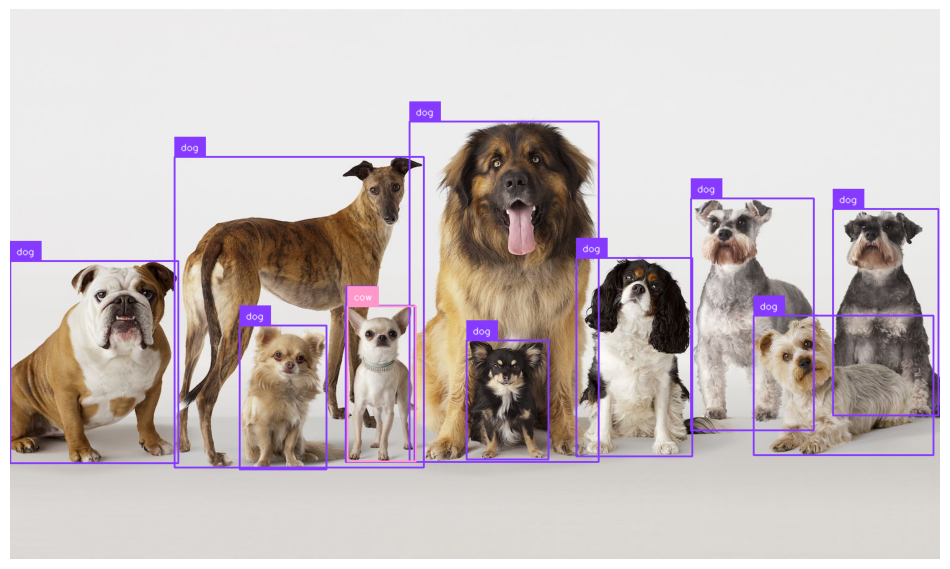

In [24]:
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    results.names[class_id]
    for class_id
    in detections.class_id
]

annotated_image = bounding_box_annotator.annotate(
    scene = image, detections = detections
)

annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections, labels=labels
)

sv.plot_image(annotated_image)


## Download the sample video

In [19]:
import requests
import re

# Define the file ID and the base URL
file_id = '1K15ijbTl78VSOPjfvGSgvqh7ME2U7cG2'
base_url = 'https://docs.google.com/uc?export=download'

# Start the session and get the confirmation token
session = requests.Session()
response = session.get(base_url, params={'id': file_id}, stream=True)
for key, value in response.cookies.items():
    if key.startswith('download_warning'):
        token = value
        break
else:
    token = None

# If a confirmation token is present, use it to download the file
if token:
    response = session.get(base_url, params={'id': file_id, 'confirm': token}, stream=True)

# Save the file
with open('video.mp4', 'wb') as f:
    for chunk in response.iter_content(chunk_size=32768):
        if chunk:
            f.write(chunk)

print('Download complete!')


Download complete!


## Video Information

In [6]:
VIDEO = "video.mp4"

colors = sv.ColorPalette.DEFAULT
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info

VideoInfo(width=1920, height=1080, fps=29, total_frames=1275)

## Save the first frame from the video

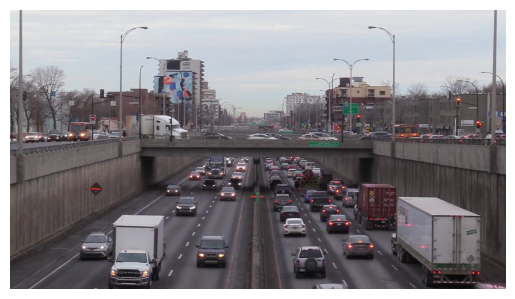

In [9]:
# extract one image from the video (frame)
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator) #loop over the frames

frame = next(iterator) #get the first frame

# save first frame
cv2.imwrite("first_frame.png", frame)
image = cv2.imread(os.path.join(HOME, "first_frame.png"))

# Convert BGR to RGB (OpenCV uses BGR by default)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image inline in the Jupyter notebook
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

## Draw Polygons
Using the tools from [Roboflow](https://roboflow.github.io/polygonzone/)

In [10]:
polygons = [
    np.array([
    [930, 1059],[946, 571],[714, 571],[18, 1051],[930, 1059]
    ]),
    np.array([
    [1042, 1059],[970, 563],[1154, 563],[1910, 1035],[1034, 1059]
    ])
]

In [12]:
zones = [
    sv.PolygonZone(
        polygon=polygon
    )
    for polygon
    in polygons
]

In [25]:
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]

In [26]:
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        )
    for index in range(len(polygons))
]

## Test the Polygons zone onto the video frame

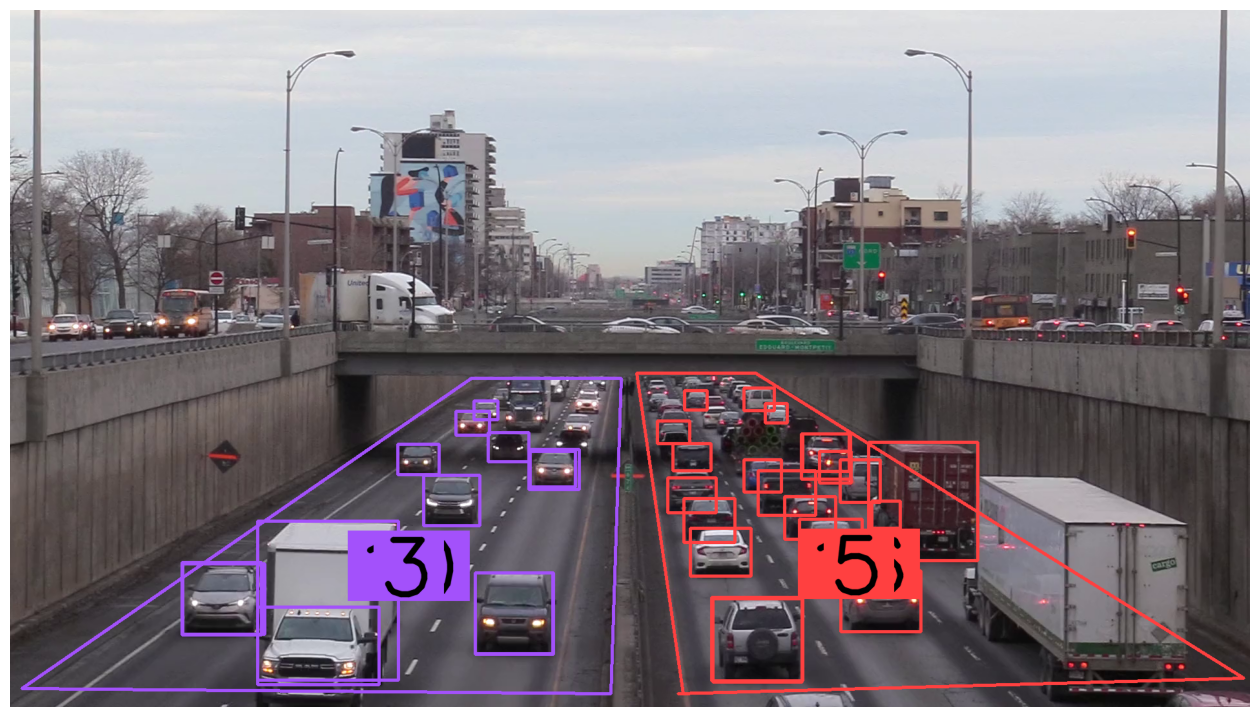

In [27]:
results = model(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

## Implement the Polygon zone onto the video

In [31]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
        frame = zone_annotator.annotate(scene=frame)

    return frame

## Save the processed video

In [32]:
sv.process_video(source_path=VIDEO, target_path="result.mp4", callback=process_frame)